<a href="https://colab.research.google.com/github/drkrillo/DATASCIENCE/blob/main/DS_03_Pasutti_con_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 3: NLP

En este proyecto se brindan tres datasets, para entrenamiento, desarrollo y prueba, que consisten en Reviews hechas por usuarios acerca de un producto de Amazon y su correspondiente puntuación, del 1 al 5.

El objetivo es analizar y procesar los datos para luego crear un modelo que prediga el valor de puntuación del usuario basásandose en sus reseñas.

## Tabla de Contenidos:
1.[Importando Librerías y Datos](#imp)
2. [EDA(Análisis exploratorio de Datos](#eda)
    * 2.1 [Datos y forma](#dat)
    * 2.2 [¿Valores faltantes?](#falt)
    * 2.3 [Distribución de target](#dist)
    * 2.4 [Descripción](#desc)
    + 2.5 [Observaciones](#obs)
3. [Preprocesamiento](#prepro)
    * 3.1 [Stemmización](#ej)
    * 3.2 [Modelo Benchmark](##bench) 
      * 3.2.1 [Observaciones](#obs2)
    * 3.3 [Lemmatización](#lemma)
      * 3.3.1 [Observaciones](#obs3)
    * 3.4 [Comparación Bag of Words y TF-IDF](#comp)
      * 3.4.1 [Observaciones](#obs4)
    * 3.5 [Binarización del Target](#bin)
      * 3.5.2 [Observaciones](#obs5)
    * 3.6 [Balanceo de Clases](#bal)
      * 3.6.1 [Resampling](#resamp)
4. [Modelado](#mod)
    * 4.1 Hyperparameter Tuning
    * 4.2 [Testing](#test)
    * 4.3 [Observaciones Finales](#obs5)
5. [Conclusiones y Cierre del Trabajo](#cierre)


In [ ]:
!pip install --upgrade spacy
!python -m spacy download es_core_news_lg

     |████████████████████████████████| 5.8 MB 4.4 MB/s 
     |████████████████████████████████| 10.1 MB 21.2 MB/s 
     |████████████████████████████████| 456 kB 49.1 MB/s 
     |████████████████████████████████| 621 kB 37.1 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 568.4 MB 12 kB/s 
✔ Download and installation successful
You can

<a id = 'imp'></a>

In [ ]:
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import itertools
import sklearn
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score
import seaborn as sns
import os
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#train = pd.read_json('dataset_es_train.json', lines = True)
#print(train.head(), '\n', train.shape)

#dev = pd.read_json('dataset_es_dev.json', lines = True)
#print(dev.head(), '\n', train.shape)

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/DATASCIENCE

/content/gdrive/MyDrive/DATASCIENCE


In [ ]:
train = pd.read_json('dataset_es_train.json', lines = True)
test = pd.read_json('dataset_es_test.json', lines = True)
dev = pd.read_json('dataset_es_dev.json', lines = True)

<a id = 'eda'></a>
## EDA

Ahora que están importadas las librearías y los datos, ya se puede comenzar el análisis.
Las preguntas que vale la pena hacerse son:
* ¿Cuántas instancias tenemos en cada set?
* ¿Hay valores faltantes?
* ¿Están balanceadas las clases?
* ¿Qué features serán de interés?

<a id='dat'></a>

In [ ]:
print('Algunas intancias de Train y su forma: ')
train.head(), train.tail(), train.shape

Algunas intancias de Train y su forma: 


(    review_id          product_id  ... language  product_category
 0  es_0491108  product_es_0296024  ...       es       electronics
 1  es_0869872  product_es_0922286  ...       es       electronics
 2  es_0811721  product_es_0474543  ...       es         drugstore
 3  es_0359921  product_es_0656090  ...       es          wireless
 4  es_0068940  product_es_0662544  ...       es             shoes
 
 [5 rows x 8 columns],
          review_id          product_id  ... language  product_category
 199995  es_0715276  product_es_0317036  ...       es       electronics
 199996  es_0085190  product_es_0622919  ...       es       electronics
 199997  es_0484496  product_es_0358101  ...       es           apparel
 199998  es_0930141  product_es_0788855  ...       es               toy
 199999  es_0859809  product_es_0378794  ...       es              home
 
 [5 rows x 8 columns],
 (200000, 8))

In [ ]:
print('Algunas intancias de Dev y su forma: ')
dev.head(), dev.tail(), dev.shape

Algunas intancias de Dev y su forma: 


(    review_id          product_id  ... language  product_category
 0  es_0417480  product_es_0873923  ...       es          wireless
 1  es_0180432  product_es_0713146  ...       es           apparel
 2  es_0144850  product_es_0356874  ...       es            sports
 3  es_0339629  product_es_0939832  ...       es  home_improvement
 4  es_0858362  product_es_0489066  ...       es            beauty
 
 [5 rows x 8 columns],
        review_id          product_id  ... language  product_category
 4995  es_0179515  product_es_0158275  ...       es              home
 4996  es_0894902  product_es_0953259  ...       es            camera
 4997  es_0760496  product_es_0731995  ...       es               toy
 4998  es_0178380  product_es_0402051  ...       es          wireless
 4999  es_0810087  product_es_0684221  ...       es           apparel
 
 [5 rows x 8 columns],
 (5000, 8))

In [ ]:
print('Algunas intancias de Test y su forma: ')
test.head(), test.tail(), test.shape

Algunas intancias de Test y su forma: 


(    review_id          product_id  ... language        product_category
 0  es_0038754  product_es_0113523  ...       es                wireless
 1  es_0748979  product_es_0017036  ...       es                    home
 2  es_0411746  product_es_0138642  ...       es                     toy
 3  es_0786686  product_es_0170887  ...       es                    home
 4  es_0429700  product_es_0710642  ...       es  digital_ebook_purchase
 
 [5 rows x 8 columns],
        review_id          product_id  ... language  product_category
 4995  es_0685611  product_es_0919143  ...       es          wireless
 4996  es_0638242  product_es_0636134  ...       es          wireless
 4997  es_0760108  product_es_0078583  ...       es              home
 4998  es_0070806  product_es_0359350  ...       es            sports
 4999  es_0794544  product_es_0130307  ...       es       electronics
 
 [5 rows x 8 columns],
 (5000, 8))

<a id='falt'></a>

In [ ]:
print('Datos Faltantes en Train')
train.isna().sum()

Datos Faltantes en Train


review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

In [ ]:
print('Datos Faltantes en Dev')
dev.isna().sum()

Datos Faltantes en Dev


review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

In [ ]:
print('Datos Faltantes en Test')
test.isna().sum()

Datos Faltantes en Test


review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

<a id = 'dist'></a>

Text(0.5, 1.0, 'Distribución de las clases en Train')

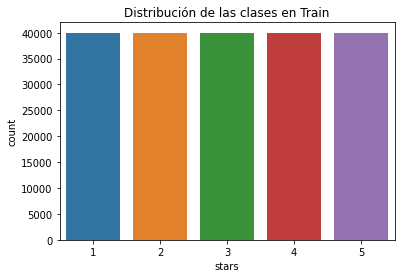

In [ ]:
sns.countplot(x = train.stars)
plt.title('Distribución de las clases en Train')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribución de las clases en Test')

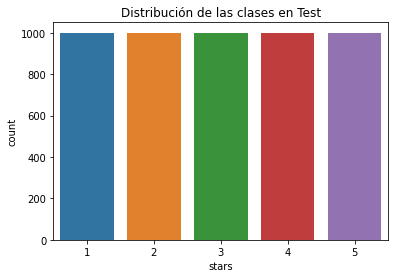

In [ ]:
sns.countplot(test.stars)
plt.title('Distribución de las clases en Test')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribución de las clases en Test')

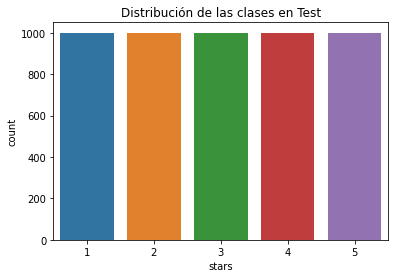

In [ ]:
sns.countplot(dev.stars)
plt.title('Distribución de las clases en Test')

<a id = 'desc'>

In [ ]:
print('Descripción de Train')
train.describe()

Descripción de Train


,stars
count,200000.000000
mean,3.000000
std,1.414217
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [ ]:
print('Descripción de Test')
test.describe()

Descripción de Test


,stars
count,5000.000000
mean,3.000000
std,1.414355
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [ ]:
print('Descripción de Dev')
dev.describe()

Descripción de Dev


,stars
count,5000.000000
mean,3.000000
std,1.414355
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


<a id = 'obs'></a>
## Observaciones

Como se puede observar de los gráficos, ** las clases están balanceadas, y no tenemos valores faltantes**. las columnas de nuestro interés son el target, el id, y el título y descripción del review. Se probarán tanto los títulos como los cuepos de las reviews para el modelo. De las filas vistas se puede decir que las descripciones completas sean mejores predictoras, brindan más información.
<a id = 'prepro'></a>
# Preprocesamiento

Para este proceso, se usará NLTK para implementar el método **Bag of Words** sobre los títulos. Se testeará el desempeño de la librería con algunos ejemplos. 
El proceso completo involucra:
* Normalización de texto: mayúsculas, signos de puntuación.
* Separación en tokens(palabras).
* Eliminación de **stopwords**(palabras como conectores)
* **Stemmización/Lemmatización**, que permiten extraer la raíz de una palabra. Con NLTK, la lemmatización no está disponible en español.

<a id = 'ej'></a>

In [ ]:
stopwords = stopwords.words('spanish')

In [ ]:
s = train.iloc[2,4]

<a id = "ej"></a>


In [ ]:
words = nltk.word_tokenize(s)
words=[word.lower() for word in words if word.isalpha()]
s

'Te obligan a comprar dos unidades y te llega solo una y no hay forma de reclamar, una autentica estafa, no compreis!!'

In [ ]:
words

['te',
 'obligan',
 'a',
 'comprar',
 'dos',
 'unidades',
 'y',
 'te',
 'llega',
 'solo',
 'una',
 'y',
 'no',
 'hay',
 'forma',
 'de',
 'reclamar',
 'una',
 'autentica',
 'estafa',
 'no',
 'compreis']

In [ ]:
titular_wt_sin_sw = [p for p in words if p not in stopwords]
titular_wt_sin_sw

['obligan',
 'comprar',
 'dos',
 'unidades',
 'llega',
 'solo',
 'forma',
 'reclamar',
 'autentica',
 'estafa',
 'compreis']

In [ ]:
from unicodedata import normalize

def stemmer(serie):
    stemm = []

    for i in serie:
        words = i #seleccionar el titular
        words = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", words), 0, re.I
        )

        words = normalize( 'NFC', words)

        words = nltk.word_tokenize(words) #Tokenizar
        words = [word.lower() for word in words if word.isalpha()] #Normalizar
        words = [x for x in words if x not in stopwords] # Filtrar por stopwords
        words = [PorterStemmer().stem(x) for x in words] #Stemmizar
        words = " ".join(words)
        stemm.append(words)
    return stemm

In [ ]:
stemm_dev = stemmer(dev.review_title)

In [ ]:
stemm_dev[5], stemm_dev[250], stemm_dev[0]

('bola rota', 'crece pelo solo suaviza', 'mala compra')

In [ ]:
list_titulos_dev = list(stemm_dev)

In [ ]:
# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000
ngram = (1,1)

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features,
                        ngram_range = ngram) 

In [ ]:
matriz_titulos_dev = cou_vec.fit_transform(list_titulos_dev)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",all_words[0:50])

50 palabras mas usadas:  ['abierta', 'abriga', 'aburrido', 'acabado', 'acept', 'aconsej', 'acord', 'adapt', 'adapta', 'adaptador', 'adaptar', 'adecuado', 'adema', 'adherencia', 'admit', 'afeitar', 'agarr', 'agrad', 'agua', 'aguanta', 'agujero', 'ahora', 'air', 'ajust', 'ajusta', 'alberto', 'alegr', 'alejandro', 'aleman', 'alfombra', 'alivia', 'alta', 'altavoz', 'altura', 'aluminio', 'amarilla', 'amarillea', 'amazon', 'ameno', 'amplia', 'ana', 'ancha', 'angel', 'anilla', 'anonimo', 'antena', 'anterior', 'antonio', 'anunciado', 'anuncio']


<a id= 'bench'></a>
# Modelo Benchmark

Ahora que tenemos stemmizados nuestro títulos, que es con los datos que haremos nuestro primer modelado, definiremos tres algoritmos predictivos diferentes, e iremos iterando nuestros datos procesados de iferente manera para ver cuál se desempeña mejor y con qué tipo de preprocesamiento.
Se utilizarán Máquinas de Descenso por Gradiente, RandomForest y Light GBM.

In [ ]:
xdev = matriz_titulos_dev.toarray()
ydev = dev.stars.values

xdev.shape

(5000, 1000)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(xdev,ydev,test_size=0.2,random_state=42,stratify=ydev)

In [ ]:
import sklearn.metrics

In [ ]:
from sklearn.preprocessing import label_binarize
labels = [1,2,3,4,5]

In [ ]:
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
svc = SVC(C = 0.7, kernel = 'poly', random_state = 42)
lgb = lgb.LGBMClassifier()
rf = RandomForestClassifier(n_estimators = 1000,
                            min_samples_leaf = 2,
                            max_depth = 3)
models = [svc, rf, lgb]

 Accuracy en Train: 0.67225
 ROC AUC en Train: 0.79515625
 Accuracy en Test: 0.37
 ROC AUC en Test: 0.60625


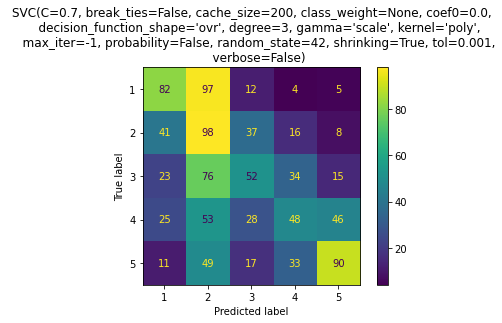

 Accuracy en Train: 0.4125
 ROC AUC en Train: 0.6328125
 Accuracy en Test: 0.335
 ROC AUC en Test: 0.584375


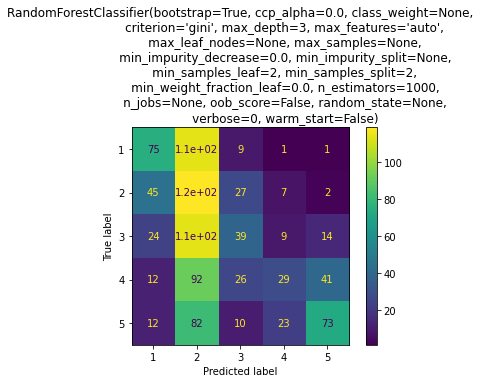

 Accuracy en Train: 0.3805
 ROC AUC en Train: 0.6128125
 Accuracy en Test: 0.326
 ROC AUC en Test: 0.57875


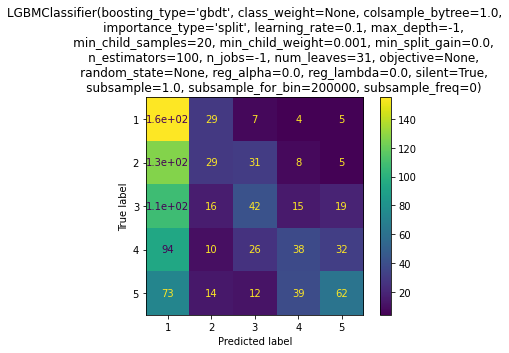

In [ ]:
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, accuracy_score

def eval(X_train, X_test, y_train, y_test):

    for model in models:

        model.fit(X_train,y_train)
        y_p = model.predict(X_train)
        y_tp = model.predict(X_test)
        y_p = label_binarize(y_p, classes = labels)
        y_tp = label_binarize(y_tp, classes = labels)
        y_train_b = label_binarize(y_train, classes = labels)
        y_test_b = label_binarize(y_test, classes = labels)

        print(" Accuracy en Train:",accuracy_score(y_train_b, y_p))
        print(" ROC AUC en Train:",roc_auc_score(y_train_b, y_p, multi_class='ovr'))

        print(" Accuracy en Test:",accuracy_score(y_test_b, y_tp))
        print(" ROC AUC en Test:",roc_auc_score(y_test_b, y_tp, multi_class='ovr'))
        plot_confusion_matrix(model, X_test, y_test)  
        plt.title(model)
        plt.show()

eval(X_train, X_test, y_train, y_test)

<a id= 'bench'></a>

## Observaciones

Como se puede apreciar, la librería NLTK tiene ciertos problemas analizando el español. En las palabras más frecuentes, figuran "abierta" y "abierto", "adapt" y "adaptador", por lo que el Stemmer no está funcionando correctamente. 
Por otro lado, se puede ver que las métricas de evaluciacón no son buenas, por lo que es innecesario tunear parámetros a estas alturas. **El modelo no de predice bien**, y no hay tuneo de hiperparámetro que pueda arreglar eso. 

Con respecto a los primeros modelos, vemos que el algoritmo tiende a predecir mal, y a sólo predecir una clase. Como objetivo, se intetará crear una zona de densidad de predicciones en la diagonal.

# Lemmatización

Una manera más correcta de cortar las raíces de una palabra es a través de la lemmatización. Pero esta funcionalidad no está disponible para el idioma español en la librería NLTK. Por esta razón, se utilizará la librería **spaCy** y uno de sus diccionarios en español, **es_core_news_sm**.

In [ ]:
import spacy
import string
from spacy.lang.es import Spanish
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from spacy.lang.es.stop_words import STOP_WORDS

In [ ]:
stopwords = spacy.lang.es.stop_words.STOP_WORDS
nlp = spacy.load('es_core_news_lg')

In [ ]:
import re
import unicodedata
import string

punct = string.punctuation

def spacy_tokenizer(serie):
    lemm = []
    for mydoc in serie:

        pattern = r'[^a-zA-z0-9\s]' 
        mytokens = re.sub(pattern, '', str(mydoc))
        pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
        mytokens = re.sub(pattern, '', str(mytokens))
        mytokens = nlp(mytokens)
        mytokens = [ word for word in mytokens if word.pos_ != "-PRON-"]
        # Removing stop words
        mytokens = [ word.lemma_ for word in mytokens if word not in stopwords or punct]
        mytokens = [word.lower() for word in mytokens if word.isalpha()] #Normalizar

        # return preprocessed list of tokens
        mytokens = " ".join(mytokens)
        lemm.append(mytokens)

    return lemm

In [ ]:
bow_vector = CountVectorizer(max_features = 1998, ngram_range=(1,2))

In [ ]:
list_titulos_dev = spacy_tokenizer(dev.review_title)
list_titulos_dev = list(list_titulos_dev)
matriz_titulos_dev = bow_vector.fit_transform(list_titulos_dev)

# Tomamos las palabras
all_words = bow_vector.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",all_words[0:50])

xdev = matriz_titulos_dev.toarray()
ydev = dev.stars.values

xdev.shape

50 palabras mas usadas:  ['abierto', 'abriga', 'aburrido', 'acabado', 'acabar', 'aceptable', 'aconsejable', 'acorde', 'adaptador', 'adaptar', 'adecuado', 'adems', 'adherencia', 'admitir', 'afeitar', 'agarre', 'agradable', 'agua', 'aguantar', 'agujero', 'ahorrar', 'aire', 'ajustado', 'ajustar', 'ajuste', 'al', 'alberto', 'alegre', 'alejandro', 'alfombra', 'algo', 'alguno', 'aliviar', 'altavoz', 'alto', 'altura', 'amazon', 'amplio', 'an', 'ana', 'ancho', 'andar', 'anillas', 'annimo', 'antena', 'anterior', 'antes', 'antonio', 'anunciado', 'anunciar']


(5000, 1000)

In [ ]:
x = dev.iloc[3,4]
x = nlp(x)
for word in x:
  print(word.text, word.pos_)

Utilicé VERB
las DET
brocas NOUN
de ADP
menor ADJ
diámetro NOUN
y CCONJ
se PRON
me PRON
doblaron VERB
varias PRON
como SCONJ
si SCONJ
fuesen AUX
de ADP
mantequilla NOUN
, PUNCT
al ADP
hacer VERB
una DET
mínima ADJ
presión NOUN
sobre ADP
ellas PRON
. PUNCT
Una DET
vez NOUN
dobladas ADJ
, PUNCT
al ADP
intentar VERB
enderezarlas VERB
, PUNCT
se PRON
parten VERB
. PUNCT
Exteriormente ADV
son AUX
amarillas ADJ
pero CCONJ
el DET
interior NOUN
es AUX
como SCONJ
de ADP
un DET
fundido NOUN
gris ADJ
. PUNCT
La DET
peor ADJ
compra NOUN
que PRON
he AUX
hecho VERB
en ADP
bastante DET
tiempo NOUN
. PUNCT


 Accuracy en Train: 0.633
 ROC AUC en Train: 0.7699798748118061
 Accuracy en Test: 0.36
 ROC AUC en Test: 0.602235436125153


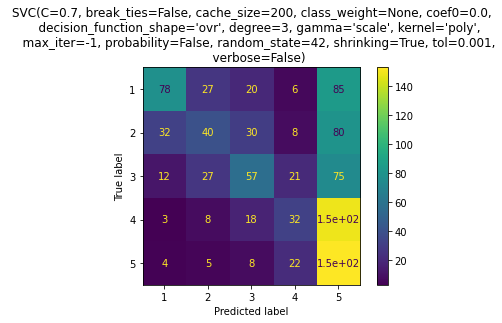

 Accuracy en Train: 0.3955
 ROC AUC en Train: 0.6215812072674508
 Accuracy en Test: 0.365
 ROC AUC en Test: 0.6057274034648276


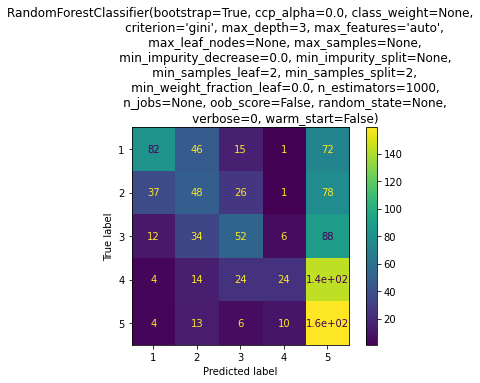

 Accuracy en Train: 0.45775
 ROC AUC en Train: 0.6619546577553844
 Accuracy en Test: 0.397
 ROC AUC en Test: 0.6201410333234177


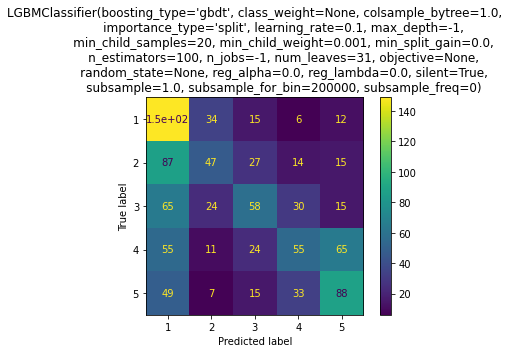

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xdev,ydev,test_size=0.2,random_state=42)
eval(X_train,X_test,y_train,y_test)

<a id = 'obs3'></a>
# Observaciones

Comparando los resultados del dataset de desarrollo con Stemmización y Lemmatización, el segundo obtiene mejores resultados: eso puede observarse en las métricas que se eligieron y que vienen acompañadas de su gráfico de confusión. Este último también operta información útil, vemos que la diagonal comienza a tener más valores.

Continuando con el análisis, se probarán dos algoritmos de lemmatización diferentes, dejando de lado algunas clases de palabras en uno de los casos, y se observrán los resultados sobre los mismos modelos.

### Cambiando de feature

Es evidente que la descri´ción de la Review otorga más información que solamente el título. Pasaremos entonces a usar esta feature para nuestras futuras predicciones.

<a id='comp'></a>
# Comparando Bag of Words y TF-IDF

Ahora que tenemos definido que usaremos el segundo lemmatizador **spacy_tokenizer2** sobre la descripción completa de los reviews, se probarán los dos métodos para vectorizar las oraciones: Bag of Words y TF-IDF.

Si se quisiera dar un paso más, deberíamos ir hacia las redes neuronales y algún modelo pre-entrenado. Dadas las condiciones de este curso, y para esta ocación, dejaremos eso para otro momento.

 Accuracy en Train: 0.4845
 ROC AUC en Train: 0.6770239673654779
 Accuracy en Test: 0.288
 ROC AUC en Test: 0.5583982701649827


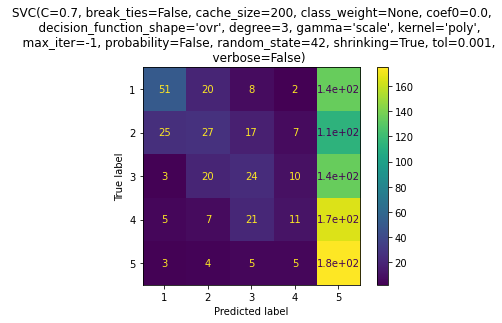

 Accuracy en Train: 0.47
 ROC AUC en Train: 0.6685878327708711
 Accuracy en Test: 0.413
 ROC AUC en Test: 0.6346790993666109


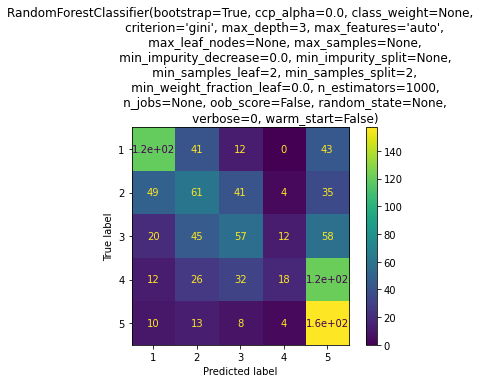

 Accuracy en Train: 0.80425
 ROC AUC en Train: 0.8777411407404703
 Accuracy en Test: 0.459
 ROC AUC en Test: 0.6613586570606653


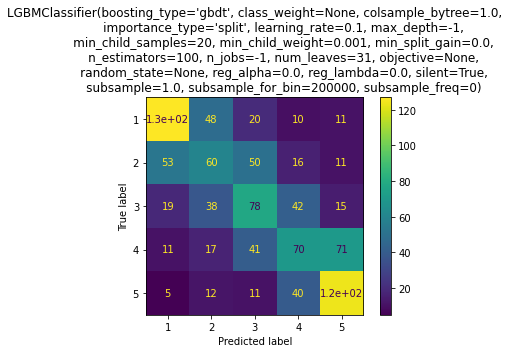

In [ ]:
list_titulos_dev = spacy_tokenizer(dev['review_body'])
list_titulos_dev = list(list_titulos_dev)

matriz_titulos_dev = bow_vector.fit_transform(list_titulos_dev)

xdev = matriz_titulos_dev.toarray()
ydev = dev.stars.values

xdev.shape

X_train, X_test, y_train, y_test = train_test_split(xdev,ydev,test_size=0.2,random_state=42)
eval(X_train,X_test,y_train,y_test)

 Accuracy en Train: 0.9965
 ROC AUC en Train: 0.9978055143440638
 Accuracy en Test: 0.32
 ROC AUC en Test: 0.5824428698784303


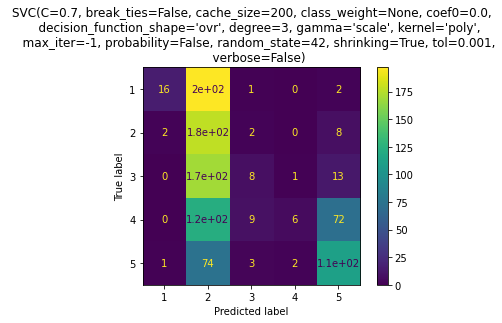

 Accuracy en Train: 0.508
 ROC AUC en Train: 0.691698546246193
 Accuracy en Test: 0.412
 ROC AUC en Test: 0.6361581042835797


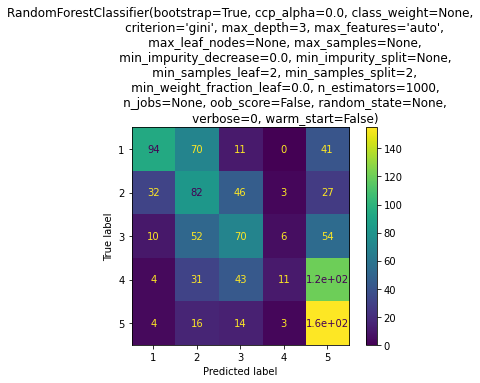

 Accuracy en Train: 0.89525
 ROC AUC en Train: 0.9345570950420872
 Accuracy en Test: 0.408
 ROC AUC en Test: 0.6300103292341434


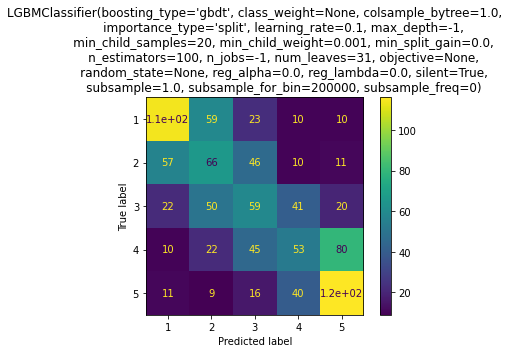

In [ ]:
tfidf_vector = TfidfVectorizer()

list_titulos_dev = spacy_tokenizer(dev['review_body'])
list_titulos_dev = list(list_titulos_dev)

matriz_titulos_dev = tfidf_vector.fit_transform(list_titulos_dev)

xdev = matriz_titulos_dev.toarray()
ydev = dev.stars.values

xdev.shape

X_train, X_test, y_train, y_test = train_test_split(xdev,ydev,test_size=0.2,random_state=42)
eval(X_train,X_test,y_train,y_test)

<a id = 'obs4'></a>
# Observaciones

Como se puede apreciar de las métricas de error, la mejoría no es proporcional al costo computacional que requiere pasar de Bag of Words a TF-IDF. Continuaremos de acá en más con este vectorizador.

<a id = 'bin'></a>
# Binarización del Target

Dado que las clases se confunden más con las que están mas cerca, y que una review de 1 o 2 estrellas es sin duda mala, mientras que una de 4 o 5, buena, para mejorar la performance del modelo binarizaremos el target de la siguiente manera:
**De 1 a 3 estrellas, la calificación es de 0, negativa**
**De 4 a 5 estrellas, la calificación es de 1, positiva**

Probaremos esto con Bag of Words y TF-IDF para ver si en este caso puede apreciarse un cambio en la performance.


In [ ]:
import lightgbm as lgb
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='binary' #Binary target feature
params['metric']='binary_logloss' #metric for binary classification
params['max_depth']=10
#
lgb2 = lgb.LGBMClassifier(**params)

def eval2(X_train, X_test, y_train, y_test):

    for model in models:

        model.fit(X_train,y_train)
        y_p = model.predict(X_train)
        y_tp = model.predict(X_test)
        y_train = label_binarize(y_train, classes =[0,1])
        y_test = label_binarize(y_test, classes =[0,1])
        y_p = label_binarize(y_p, classes =[0,1])
        y_tp = label_binarize(y_tp, classes =[0,1])        
        print('Accuracy en Train ', accuracy_score(y_train, y_p))
        print('Accuracy en Test ', accuracy_score(y_test, y_tp))
        print('ROC AUC en Train ', roc_auc_score(y_train, y_p))
        print('ROC AUC en Test ', roc_auc_score(y_test, y_tp))

        plot_confusion_matrix(model, X_test, y_test)  
        plt.title(model)
        plt.show()

In [ ]:
list_titulos_dev = spacy_tokenizer(dev['review_body'])
list_titulos_dev = list(list_titulos_dev)

matriz_titulos_dev = bow_vector.fit_transform(list_titulos_dev)

xdev = matriz_titulos_dev.toarray()

ydev = dev.stars.values
ydev = ydev >= 4
ydev = 1*ydev

Accuracy en Train  0.826
Accuracy en Test  0.802
ROC AUC en Train  0.8043418773824306
ROC AUC en Test  0.7710865180741583


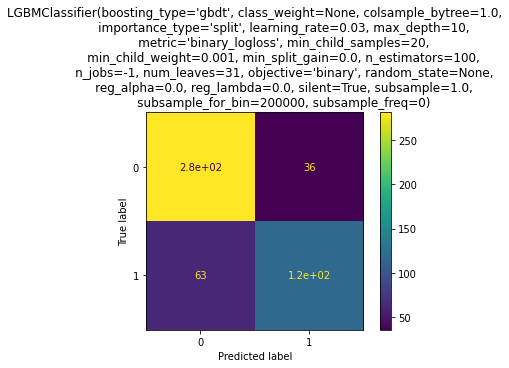

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xdev,ydev,test_size=0.1,random_state=42)
models = [lgb2]
eval2(X_train,X_test,y_train,y_test)

In [ ]:
def spacy_tokenizer2(serie):
    lemm = []
    for mydoc in serie:

        pattern = r'[^a-zA-z0-9\s]' 
        mytokens = re.sub(pattern, '', str(mydoc))
        pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
        mytokens = re.sub(pattern, '', str(mytokens))
        mytokens = nlp(mytokens)
        mytokens = [ word for word in mytokens if word.pos_ != ("-NOUN-") and ("-PRON-") and ("-PROPN-") and ("-AUX-") and ("-ADP-")]
        # Removing stop words
        mytokens = [word for word in mytokens if word not in stopwords and punct]

        mytokens = [ word.lemma_ for word in mytokens]
        mytokens = [word.lower() for word in mytokens if word.isalpha()] #Normalizar
        # return preprocessed list of tokens
        mytokens = " ".join(mytokens)
        mytokens = mytokens.replace('amazon', '')

        lemm.append(mytokens)

    return lemm

Accuracy en Train  0.8277777777777777
Accuracy en Test  0.796
ROC AUC en Train  0.8068985895621569
ROC AUC en Test  0.7640447501335954


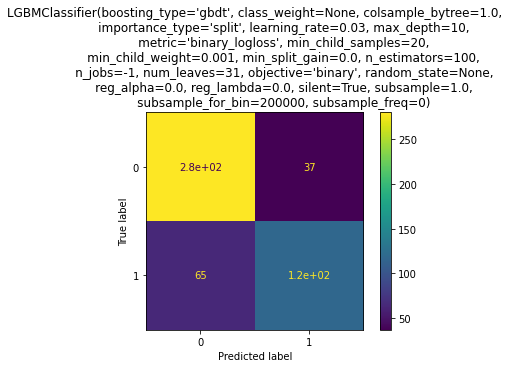

In [ ]:
list_titulos_dev = spacy_tokenizer2(dev['review_body'])
list_titulos_dev = list(list_titulos_dev)
matriz_titulos_dev = bow_vector.fit_transform(list_titulos_dev)

xdev = matriz_titulos_dev.toarray()

ydev = dev.stars.values
ydev = ydev >= 4
ydev = 1*ydev

X_train, X_test, y_train, y_test = train_test_split(xdev,ydev,test_size=0.1,random_state=42)
models = [lgb2]
eval2(X_train,X_test,y_train,y_test)

<a id = 'bal'></a>
# Balanceo de Clases

Al binarizar el problema, las clases quedan desbalanceadas: 0.6 de la muestra tiene puntuación negativa y 0.4 tiene puntuación positiva.

De la tabla anterior, se puede observar que las opiniones están divididas en las 3 estrellas, y que hay puntuaciones positivas y negativas. Por ende, es una clase ambigua. 
<a id = "resamp"></a>
## Resampling

Para solucionar este problema, existen diferentes ténicas. En este notebook se probará un sistema híbrido de resampleo, que consiste en un Re-sampling primero(aumentar el número de samples de la minoría) y un Downsampling después(reducción de la mayoría).


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

Accuracy en Train  0.828996282527881
Accuracy en Test  0.7926421404682275
ROC AUC en Train  0.8289928039956336
ROC AUC en Test  0.7926733780760626


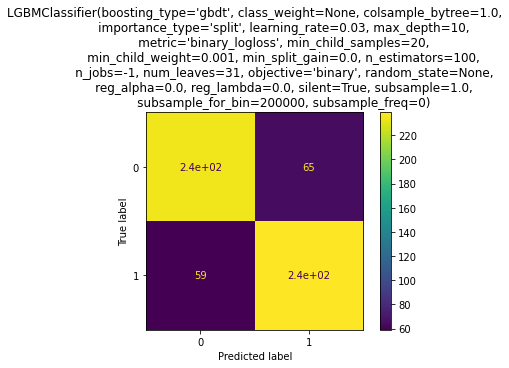

In [ ]:
from imblearn.combine import SMOTETomek

list_titulos_dev = spacy_tokenizer(dev['review_body'])
list_titulos_dev = list(list_titulos_dev)

matriz_titulos_dev = bow_vector.fit_transform(list_titulos_dev)

X = matriz_titulos_dev.toarray()

y = dev.stars >= 4
y = y*1

smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_smt,y_smt,test_size=0.1,random_state=42)
models = [lgb2]

eval2(X_train, X_test, y_train, y_test)

<a id = 'mod'></a>
# Modelado

Ahora que tenemos definido la feature que estaremos transformando, el Lemmatizador que vamos a utilizar y el modelo que se va a utilizazr(LightGBM), es tiempo de hacer un poco de Hyperparameter Tuning.

## Hyperparameter Tuning

Paraa el tuneo de hiperparámetros se usará Optuna. En la celda siguiente se instala el paquete. Se crea un estudio de tuneo, que otorga como resultado gráficos del proceso y valores de cada hiperparámetro.

In [ ]:
!pip install optuna

     |████████████████████████████████| 302 kB 5.2 MB/s 
     |████████████████████████████████| 164 kB 50.9 MB/s 
     |████████████████████████████████| 80 kB 7.6 MB/s 
     |████████████████████████████████| 75 kB 4.2 MB/s 
     |████████████████████████████████| 141 kB 51.4 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
     |████████████████████████████████| 111 kB 48.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=49a8053d9c306a800439178c5a6562186cf04c46bda4a1d2657ed7d4aeaa8261
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna.integration.lightgbm as lgb
from sklearn.model_selection import RepeatedKFold
import optuna
import numpy as np

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

params = {
        "objective": "binary",
        "metric": "binary_error",
        "verbosity": -1,
        "boosting_type": "gbdt",                
        "seed": 42
    }

X_train, X_test, y_train, y_test = train_test_split(X_smt, y_smt = test_size = 0.8, random_state = 42)

X_train = np.array(X_train)   
y_train = np.array(y_train)

study_tuner = optuna.create_study(direction='minimize')
dtrain = lgb.Dataset(X_train, label=y_train)

# Suppress information only outputs - otherwise optuna is 
# quite verbose, which can be nice, but takes up a lot of space
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# Run optuna LightGBMTunerCV tuning of LightGBM with cross-validation
tuner = lgb.LightGBMTunerCV(params, 
                            dtrain, 
                            study=study_tuner,
                            verbose_eval=False,                            
                            early_stopping_rounds=250,
                            time_budget=19800, # Time budget of 5 hours, we will not really need it
                            seed = 42,
                            folds=rkf,
                            num_boost_round=10000,
                            callbacks=[lgb.reset_parameter(learning_rate = [0.005]*200 + [0.001]*9800) ] #[0.1]*5 + [0.05]*15 + [0.01]*45 + 
                           )

tuner.run()

[I 2021-08-29 18:29:39,713] A new study created in memory with name: no-name-64fd3143-dde0-4a63-bfcd-e1950375b1d3
  0%|          | 0/5 [00:00<?, ?it/s]


In [ ]:
print(tuner.best_params)
# Classification error
print(tuner.best_score)
# Or expressed as accuracy
print(1.0-tuner.best_score)

{'objective': 'binary', 'metric': 'binary_error', 'verbosity': -1, 'boosting_type': 'gbdt', 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 103, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
0.1807960425966611
0.819203957403339


In [ ]:
import lightgbm as lgb
dtrain = lgb.Dataset(X_train, label=y_train)

# We will track how many training rounds we needed for our best score.
# We will use that number of rounds later.
best_score = 999
training_rounds = 10000

# Declare how we evaluate how good a set of hyperparameters are, i.e.
# declare an objective function.
def objective(trial):
    # Specify a search space using distributions across plausible values of hyperparameters.
    param = {
        "objective": "binary",
        "metric": "binary_error",
        "verbosity": -1,
        "boosting_type": "gbdt",                
        "seed": 42,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'seed': 1979
    }
    
    # Run LightGBM for the hyperparameter values
    lgbcv = lgb.cv(param,
                   dtrain,
                   folds=rkf,
                   verbose_eval=False,                   
                   early_stopping_rounds=250,                   
                   num_boost_round=10000,                    
                   callbacks=[lgb.reset_parameter(learning_rate = [0.005]*200 + [0.001]*9800) ]
                  )
    
    cv_score = lgbcv['binary_error-mean'][-1] + lgbcv['binary_error-stdv'][-1]
    if cv_score<best_score:
        training_rounds = len( list(lgbcv.values())[0] )
    
    # Return metric of interest
    return cv_score

# Suppress information only outputs - otherwise optuna is 
# quite verbose, which can be nice, but takes up a lot of space
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# We search for another 4 hours (3600 s are an hours, so timeout=14400).
# We could instead do e.g. n_trials=1000, to try 1000 hyperparameters chosen 
# by optuna or set neither timeout or n_trials so that we keep going until 
# the user interrupts ("Cancel run").
study = optuna.create_study(direction='minimize')  
study.enqueue_trial(tuner.best_params)
study.optimize(objective, timeout=14400)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: ExperimentalWarning:

enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.

/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:857: ExperimentalWarning:

create_trial is experimental (supported from v2.0.0). The interface can change in the future.

/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:857: ExperimentalWarning:

add_trial is experimental (supported from v2.0.0). The interface can change in the future.

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:744: UserWarning:

Fixed parameter 'lambda_l1' with value 0.0 is out of range for distribution LogUniformDistribution(high=10.0, low=1e-08).

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:744: UserWarning:

Fixed parameter 'lambda_l2' with value 0.0 is out of range for distribution LogUniformDistribution(high=10.0, low=1e-08).



In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
print(study.best_params)

{'lambda_l1': 0.00994045913809775, 'lambda_l2': 0.8631013232296978, 'num_leaves': 226, 'feature_fraction': 0.8237216975245562, 'bagging_fraction': 0.9877257613493577, 'bagging_freq': 0, 'min_child_samples': 1}


In [ ]:
# Classification error
print(study.best_value)
# Or expressed as accuracy
print(1.0-study.best_value)

0.19210744440586836
0.8078925555941316


In [ ]:
best_params = {
    "objective": "binary",
    "metric": "binary_error",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "seed": 42} 
best_params.update(study.best_params)
best_params

{'bagging_fraction': 0.9877257613493577,
 'bagging_freq': 0,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.8237216975245562,
 'lambda_l1': 0.00994045913809775,
 'lambda_l2': 0.8631013232296978,
 'metric': 'binary_error',
 'min_child_samples': 1,
 'num_leaves': 226,
 'objective': 'binary',
 'seed': 42,
 'verbosity': -1}

<a id="test"></a>
# Testing

Ya están los valores para los hiperparámetros, tokenizador, vectorizador. Ahora, se entrena todo el set de Train, y se valida con Test.

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb 

X_train = train[['review_id', 'review_body']]
X_test = test[['review_id', 'review_body']]
y_train = train.stars >=4
y_test = test.stars >=4
y_train = y_train*1
y_test = y_test*1

list_titulos_train = spacy_tokenizer(X_train['review_body'])
list_titulos_train = list(list_titulos_train)

matriz_titulos_train = bow_vector.fit_transform(list_titulos_train)

X_train = matriz_titulos_train.toarray()


In [ ]:
list_titulos_test = spacy_tokenizer(X_test['review_body'])
list_titulos_test = list(list_titulos_test)

matriz_titulos_test = bow_vector.transform(list_titulos_test)

X_test = matriz_titulos_test.toarray()

In [ ]:
X_train.shape, X_test.shape

((200000, 1998), (5000, 1998))

In [ ]:
import numpy as np

params = {'bagging_fraction': 0.9877257613493577,
    'bagging_freq': 0,
    'boosting_type': 'gbdt',
    'feature_fraction': 0.8237216975245562,
    'lambda_l1': 0.00994045913809775,
    'lambda_l2': 0.8631013232296978,
    'metric': 'binary_error',
    'min_child_samples': 1,
    'num_leaves': 226,
    'objective': 'binary',
    'seed': 42,
    'verbosity': -1}

dtrain = lgb.Dataset(X_train, label=y_train)

lgb = lgb.train(params, 
          dtrain,
          verbose_eval=False, 
          num_boost_round=10000,
          )

In [ ]:
y_pred = np.round(lgb.predict(X_test)).astype(np.int8)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

print(" Accuracy en Test:",accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)  

 Accuracy en Test: 0.8552


array([[2679,  321],
       [ 403, 1597]])

<a id = "obs5"></a>
# Observaciones Finales

El resultado de las métricas de este último modelo es el mejor alcanzado a lo largo del trabajo. Ayuda mucho haber tenido clases perfectamente balanceadas, y con contenidos similires. 

La iteración sobre la elección del tipo de modelo, del tokenizador, el vectorizador y la codificación del target, fueron llevando a un modelo optimizado que tiene una performance razonable.

<a id = "cierre"></a>

# Conclusiones y Cierre del Trabajo

